In [ ]:
'''
json返回如下：//单位（每平方米/元）
data = {
    [
        '成都周边' : 9880.5,
        '成华区' : 20779.99,
        '崇州市' : 9476.06,
        '大邑县' : 9476.99,
        '东部新区' : 10644.67,
        '都江堰市' : 9524.08,
        '高新区' : 25493.43,
        '高新西区' : 14518.27,
        '金牛区' : 20230.15,
        '金堂县' : 7251.03,
        '锦江区' : 26223.91,
        '龙泉驿区 ' : 14712.34,
        '彭州市' : 8429.05,
        '郫都区' : 12701.52,
        '蒲江县' : 7076.48,
        '青白江区' : 8201.16,
        '青羊区' : 26121.83,
        '邛崃市' : 8288.43,
        '双流区' : 16155.94,
        '简阳市' : 9001.33,
        '天府新区' : 19338.43,
        '温江区' : 13477.39,
        '武侯区' : 22938.39,
        '新都区' : 11422.79,
        '新津区' : 9820.76
    ]
}
'''

In [ ]:
'''
    安居客案例
'''
import csv
import requests
from bs4 import BeautifulSoup
import pymysql
import re

def get_one_page(url):
    header ={
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36 Edg/136.0.0.0'
    }

    r = requests.get(url,headers = header)
    r.encoding = r.apparent_encoding    #设置编码格式
    demo = r.text
    return demo


def parse_one_page(html):
    soup = BeautifulSoup(html,'html.parser')
    Homes = soup.find_all('div',class_='property')

    home_data = []
    for home in Homes:
        #房屋名字
        title = home.find('h3',class_='property-content-title-name').string.strip()

        all = home.find('div',class_='property-content-info').contents      
        all = [home for home in all if home!=' ']
        #房屋类型
        house_type = all[0].get_text().replace(' ','')   #打印出来都在span里（string也不能解决）尝试用text和get_text()提取节点文本
       
        
        area = all[1].string.strip()        #建筑面积(但是第一个div的第2个是空字符串，所以我们得去除空元素)
        direction = all[2].string.strip()   #房屋朝向
        floor = all[3].string.strip()       #房屋楼层
        year = all[4].string.strip()        #建造年代
        
        addr = home.find('p',class_='property-content-info-comm-name').contents
        plate = addr[0].string.strip()      #楼盘

        text = home.find('p',class_='property-content-info-comm-address').contents
        text = [home for home in text if home!=' ']
        address1 = text[0].string.strip()
        address2 = text[1].string.strip()
        address3 = text[2].string.strip()
        combined_address = "-".join([address1, address2, address3])

        price = home.find('p',class_='property-price-total').contents
        price = [home for home in price if home!=' ']
        home_price1 = price[0].string.strip()
        home_price2 = price[1].string.strip()
        combined_price = "".join([home_price1,home_price2])
        
        ave = home.find('p',class_='property-price-average').string.strip()

        home_data.append([title,house_type,area,direction,floor,year,plate,combined_address,home_price1,ave])
        
        print(title,house_type,area,direction,floor,year,plate,combined_address,combined_price,ave)               
    
    return home_data
        

def write_to_csv(content,path):
    with open(path,'a',newline='',encoding='utf-8-sig') as f:
        writer = csv.writer(f)
        if f.tell() == 0:
            writer.writerow(['房屋标题','房屋类型','房屋面积','房屋朝向','房屋楼层','建造年代','楼盘','房屋地址','房屋价格','每平米/元'])
        writer.writerows(content)   #写入数据


def write_to_table(content):
    #1、创建数据库链接对象connect
    db = pymysql.connect(
        host='192.168.40.135',
        port=3306,
        user='root',
        passwd='123456',
        db='home',
        charset='utf8'
    )

    #2、获取游标对象 cursor
    cursor = db.cursor()

    #3、执行SQL语句（核心步骤：建表、增删改查）
    create_table = """
    create table if not exists home_info2(
        title varchar(100) not null,
        houseType varchar(100) not null,
        area varchar(100) not null,
        direction varchar(100) not null,
        floor varchar(100) not null,
        year varchar(100) not null,
        plate varchar(200) not null,
        address varchar(200) not null,
        price varchar(100) not null,
        avePrice varchar(100) not null
    )
    """
    cursor.execute(create_table)
    db.commit()   

    #插入数据
    insert_sql = """
    insert into home_info2(title,houseType,area,direction,floor,year,plate,
    address,price,avePrice) values(%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
    """

    cursor.executemany(insert_sql,content)
    db.commit()

    db.rollback()
    # try:
    #     for i in content:
    #         cursor.execute(insert_sql,(
    #             i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7],i[8],i[9],i[10]
    #             )
    #         )
    #         db.commit()
            
    # except:
    #     db.rollback()
        
    #4、关闭游标和数据库连接
    cursor.close()
    db.close()
    
    

if __name__ == '__main__':
    for i in range(1,10):
        if i == 1:
            url = 'http://www.bspider.top/anjuke/'
        else:
            url = f'http://www.bspider.top/anjuke/?page={i}'
        html = get_one_page(url)
        #print(html)     #尝试打印编码 验证是否成功

        content = parse_one_page(html)

        #write_to_csv(content,'home_price.csv')

        #写入数据库
        write_to_table(content)




In [7]:
import pandas as pd

df = pd.read_csv('home_price.csv')
df

,房屋标题,房屋类型,房屋面积,房屋朝向,房屋楼层,建造年代,楼盘,房屋地址,房屋价格,每平米/元
0,万科物业自营 南坪六公里金域翰林 三号线精装正三房带家具电器,3室2厅1卫,89.9㎡,南北,低层(共27层),2019年建造,万科金域学府翰林菁华里,南岸-学府大道-二塘路59号,148万,16465元/㎡
1,黄泥磅 两代一家 正规三房双卫 业主自住房 拎包入住,3室2厅2卫,94.5㎡,东南,低层(共28层),2008年建造,两代一家,渝北-渝北黄泥磅-紫荆路29号,140万,14815元/㎡
2,鸳鸯16年次新小区 大雅云居山刚需经典3房户型 随时看房诚售,3室2厅1卫,88㎡,南北,低层(共24层),2016年建造,大雅云居山,渝北-鸳鸯-龙展路59号,145万,16487元/㎡
3,中交中央公园 横厅精装大两房 出门都是公园,2室2厅1卫,91㎡,南,低层(共25层),2016年建造,中交中央公园悦颂,渝北-中央公园-翠丹路4号,188万,20660元/㎡
4,富力现代广场 豪装大两房 户型方正 看房方便,2室2厅1卫,85.5㎡,南北,低层(共30层),2012年建造,富力现代广场,南岸-弹子石-弹子石新街59号,145万,16969元/㎡
...,...,...,...,...,...,...,...,...,...,...
535,公园小洋房轻轨10号线旁鹿山南北通透户型好配套完善,3室2厅2卫,97㎡,南北,中层(共8层),2021年建造,荣盛鹿山府,"渝北-中央公园-金州大道,近万康路",149万,15361元/㎡
536,！渝北中央公园洋房社区 10号轻轨房 高端品质 配套成熟,3室2厅2卫,97㎡,南北,中层(共8层),2018年建造,荣盛鹿山府,"渝北-中央公园-金州大道,近万康路",140万,14433元/㎡
537,中央公园轻轨房！3号线10号线鹿山轻轨旁！三房双卫！周边成熟,3室2厅2卫,97㎡,南北,中层(共8层),2021年建造,荣盛鹿山府,"渝北-中央公园-金州大道,近万康路",152.88万,15761元/㎡
538,！渝北中央公园洋房社区 10号轻轨房 高端品质 配套成熟,3室2厅2卫,97㎡,南北,中层(共8层),2018年建造,荣盛鹿山府,"渝北-中央公园-金州大道,近万康路",140万,14433元/㎡


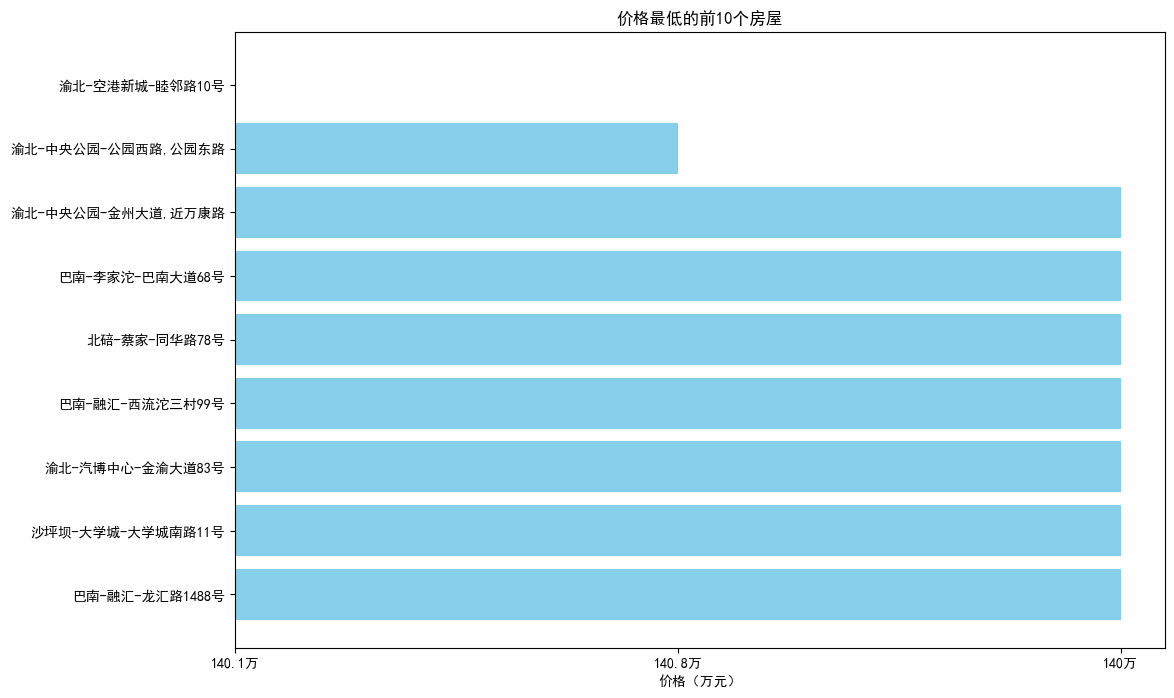

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 读取CSV文件
df = pd.read_csv('home_price.csv')

# 根据房屋价格进行升序排序
sorted_df = df.sort_values(by='房屋价格')

# 选择价格最低的前10个房屋
top_10_houses = sorted_df.head(10)

# 提取房屋标题和价格
house_titles = top_10_houses['房屋地址']
house_prices = top_10_houses['房屋价格']

# 绘制柱状图
plt.figure(figsize=(12, 8))
plt.barh(house_titles, house_prices, color='skyblue')
plt.xlabel('价格（万元）')
plt.title('价格最低的前10个房屋')
plt.gca().invert_yaxis()  # 反转y轴，使最高的价格在顶部
plt.show()


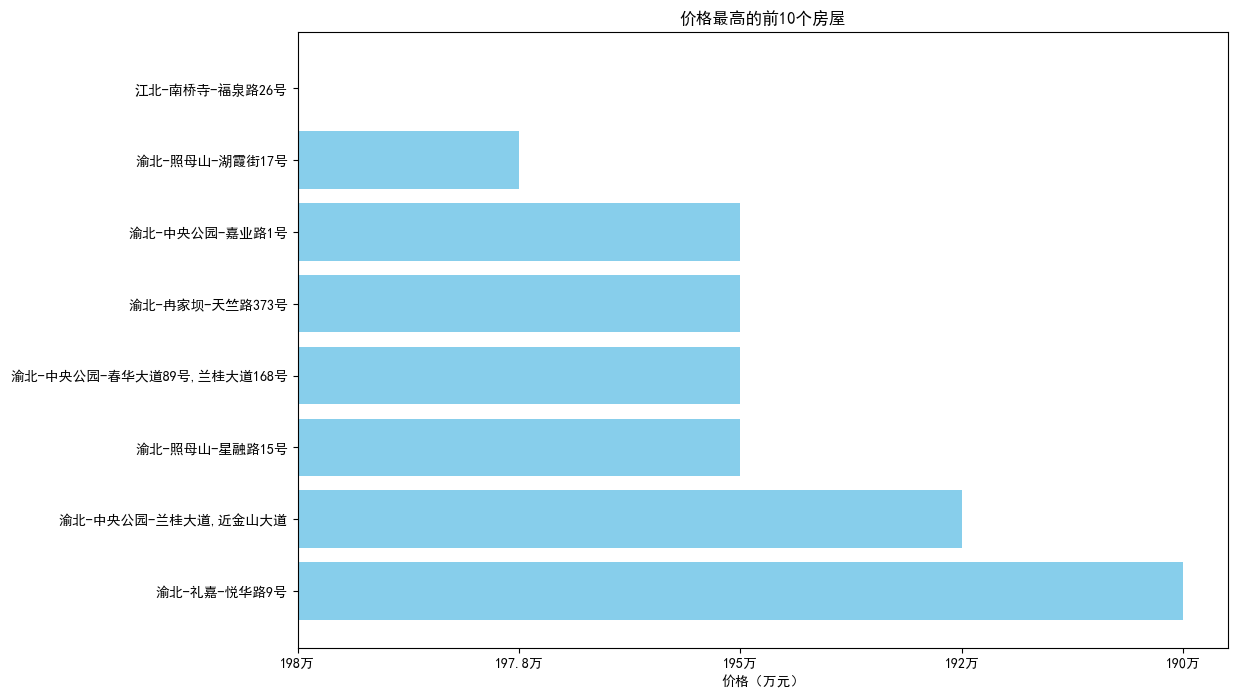

In [9]:
# 根据房屋价格进行降序排序以选择价格最高的房屋
sorted_df_desc = df.sort_values(by='房屋价格', ascending=False)

# 选择价格最高的前10个房屋
top_10_houses_desc = sorted_df_desc.head(10)

# 提取房屋标题和价格
house_titles_desc = top_10_houses_desc['房屋地址']
house_prices_desc = top_10_houses_desc['房屋价格']

# 绘制柱状图
plt.figure(figsize=(12, 8))
plt.barh(house_titles_desc, house_prices_desc, color='skyblue')
plt.xlabel('价格（万元）')
plt.title('价格最高的前10个房屋')
plt.gca().invert_yaxis()  # 反转y轴，使最高的价格在顶部
plt.show()